# Introduction to the Article Code:

This is the code used for the article posted on Medium.com. If you would like to know more about it click the link: [CRISP-DM Regression Analysis in Python](https://medium.com/p/ade4b74bdc85/edit)

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helper import cleaning_dollar
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Extracting and Merging the data:

## Calendar

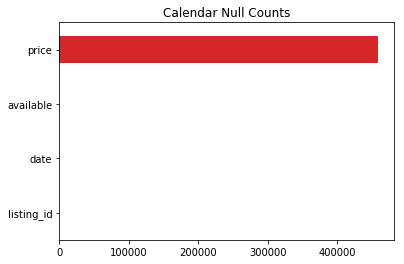

In [143]:
# Extracting the calendar dataset
df_calendar = pd.read_csv('data\seattle\calendar.csv')

# Extracting the listings dataset
target_col = ['id', 'accommodates', 'bedrooms', 'cleaning_fee', 'property_type']
df_listings = pd.read_csv('data\seattle\listings.csv')[target_col]

# Calculating null values
null_calendar = df_calendar.isnull().sum()
null_listings = df_listings.isnull().sum()

# Show Nulls on Graph
null_calendar.plot.barh(title='Calendar Null Counts');

## Listings

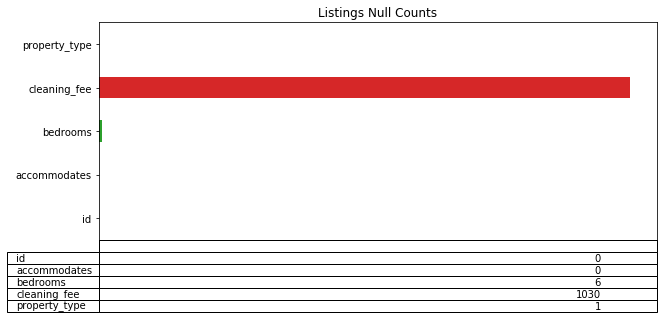

In [144]:
# Plot settings
ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

# Adding Table
table(ax, null_listings)

# Showing Graph
null_listings.plot.barh(title='Listings Null Counts', figsize=(10,4));

# Transforming and Cleaning the data:

## Calendar

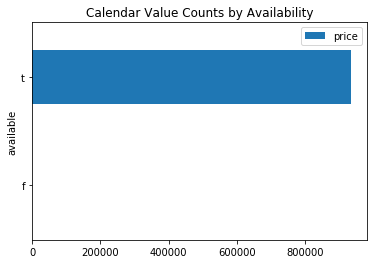

In [145]:
# Cleaning price
df_calendar.loc[:, 'price'] = df_calendar.price.str.findall(
    '[^$,]').str.join('').astype(float)

# Grouping prices by the available feature
df_calendar.groupby('available').count()[['price']].plot.barh(
    title="Calendar Value Counts by Availability");

In [146]:
# Dropping where available is f
df_calendar = df_calendar.where(lambda x: x.available=='t').dropna()

# Kepp only usefull features for the analysis
df_calendar = df_calendar[['listing_id', 'price', 'date']]

In [147]:
# Converting date to date time
df_calendar.loc[:, 'date'] = df_calendar.date.apply(pd.to_datetime)

# Adding the months ot sort on Graph
month_format = lambda x: f"#{x.month:0>2}" + ': ' + x.month_name() + ' ' +str(x.year)
month_func = lambda x: x.date.apply(month_format)
df_calendar = df_calendar.assign(month=month_func)

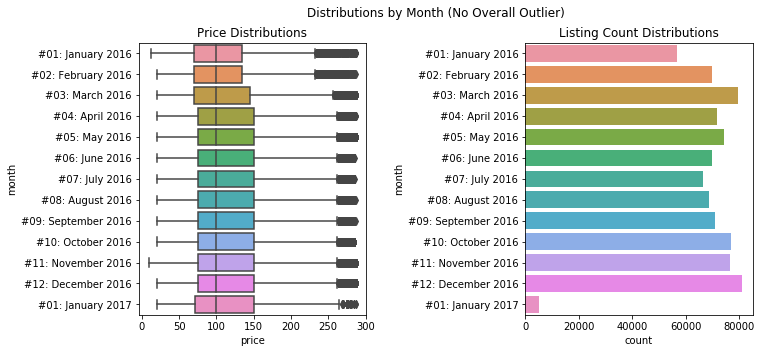

In [148]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))

plt.suptitle('Distributions by Month (No Overall Outlier)')
plt.subplots_adjust(wspace=.7)

# Statistical outlier removal
upper_quartile = df_calendar.price.quantile(.75)
lower_quartile = df_calendar.price.quantile(.25)
interquartile =  upper_quartile - lower_quartile
lower_whisker = lower_quartile - interquartile * 1.5
upper_whisker = upper_quartile + interquartile * 1.5

# Data without outlier to plot

df_calendar_noout = df_calendar.query(f"price<={upper_whisker} and price>={lower_whisker}")

# Plotting 
ax[0].set_title('Price Distributions')
sns.boxplot(x='price', y='month', data=df_calendar_noout, ax=ax[0]);

ax[1].set_title('Listing Count Distributions')
sns.countplot(y='month', data=df_calendar_noout, ax=ax[1]);

In [149]:
df_calendar.date.describe()

count                  934542
unique                    365
top       2017-01-01 00:00:00
freq                     2922
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

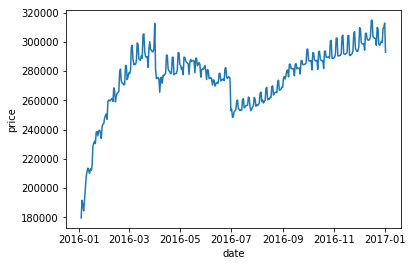

In [150]:
sns.lineplot(x='date', 
             y='price', 
             data=df_calendar_noout.groupby('date').agg({'price':'sum'}).reset_index());

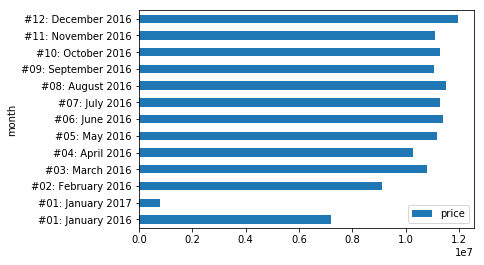

In [151]:
df_calendar.groupby('month').agg({'price':'sum'}).plot.barh()

In [152]:
# Save date references
dates = pd.Series(df_calendar.date.unique())
date_order = pd.Series(df_calendar.date.unique()).rank()

date_ref_df = pd.concat([dates, date_order], axis=1)
date_ref_df.columns = ['dates', 'date_order']

In [153]:
# Transforming dates to ordered values
df_calendar.loc[:, 'date'] = df_calendar.date.rank(method='dense')

In [154]:
# Dropping irrelevant columns
df_calendar.drop('month', axis=1, inplace=True)

## Listings 

In [155]:
# Cleaning cleaning fee
df_listings.loc[:, 'cleaning_fee'] = df_listings.cleaning_fee.str.findall(
    '[^$,]').str.join('').astype(float)

# Imputation of the Data:

## Bedroom Imputations

In [156]:
# Get mode by group into dictionary
mode = df_listings.groupby('property_type').bedrooms.apply(
    lambda x: x.value_counts().index[0]).to_dict()

# Assign the mode by mapping
mode_fill = df_listings.assign(
    bedrooms=lambda x: x.property_type.map(mode)).bedrooms

# Fill the nulls with respective modes by property_type
df_listings.bedrooms.fillna(mode_fill, inplace=True)

In [157]:
pd.DataFrame(mode, index=[0]).T

,0
Apartment,1.0
Bed & Breakfast,1.0
Boat,1.0
Bungalow,0.0
Cabin,1.0
Camper/RV,1.0
Chalet,1.0
Condominium,1.0
Dorm,1.0
House,1.0


## Cleaning Fees Imputations

In [158]:
df_listings.cleaning_fee.fillna(0, inplace=True)

## Property Type Sparsity Groupings

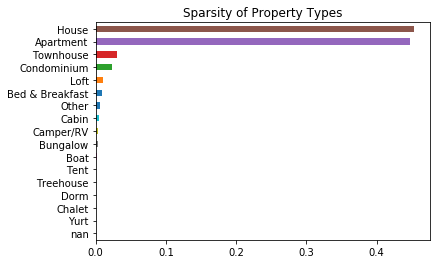

In [159]:
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='Sparsity of Property Types');

In [160]:
fn_keep_labels = lambda x: x.str.contains('House|Apartment')
df_listings.loc[:, 'property_type'] = df_listings.property_type.where(
    fn_keep_labels).fillna('Other')

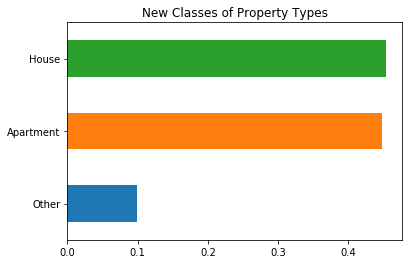

In [161]:
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='New Classes of Property Types');

# Encoding the Data:

In [162]:
# Instantiating Encoder
encoder = OneHotEncoder()

# Encoding property types
encode_matrix = encoder.fit_transform(df_listings[['property_type']])

In [163]:
# Dropping original column
#df_listings.drop('property_type', axis=1, inplace=True)

# Converting encoded data to dataframe
endoce_df = pd.DataFrame(encode_matrix.toarray(), columns=encoder.categories_[0])

# Adding columns to dataframe
df_listings = pd.concat([df_listings, endoce_df], axis=1)

In [164]:
endoce_df.head()

,Apartment,House,Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [165]:
df_listings.head()

,id,accommodates,bedrooms,cleaning_fee,property_type,Apartment,House,Other
0,241032,4,1.0,0.0,Apartment,1.0,0.0,0.0
1,953595,4,1.0,40.0,Apartment,1.0,0.0,0.0
2,3308979,11,5.0,300.0,House,0.0,1.0,0.0
3,7421966,3,0.0,0.0,Apartment,1.0,0.0,0.0
4,278830,6,3.0,125.0,House,0.0,1.0,0.0


#  Creating and Assessing the Data Model

<a id="model"></a>

In [166]:
# Creating the final Seattle data
df_seattle = df_calendar.merge(df_listings, 
                               left_on='listing_id',
                               right_on='id', 
                               how='left')

# Dropping keys
df_seattle.drop(['id', 'listing_id'], axis=1, inplace=True)

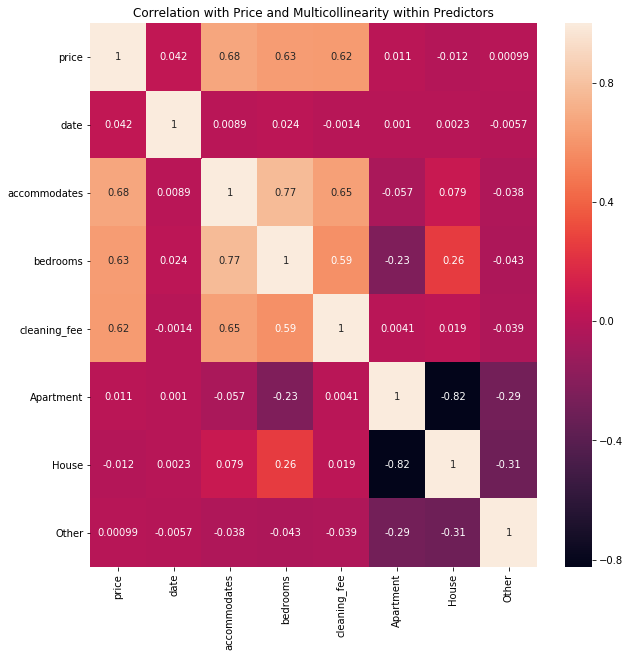

In [167]:
plt.figure(figsize=(10, 10))
plt.title("Correlation with Price and Multicollinearity within Predictors")
sns.heatmap(df_seattle.corr(), annot=True);

In [173]:
# Droping encoded columns
df_seattle.drop(['Apartment', 'House', 'Other'], axis=1, inplace=True)

KeyError: "['Apartment' 'House' 'Other'] not found in axis"

In [174]:
df_seattle.drop('property_type', axis=1, inplace=True)

# Applying and Evaluating Model

In [175]:
# Resetting index for the cross validation
df_seattle.reset_index(drop=True, inplace=True)

# Sorting time series
df_seattle = df_seattle.sort_values('date')

# Separating predictors and dependent variable
X = df_seattle.drop('price', axis=1)
y = df_seattle[['price']]

In [186]:
# Instantiating model and cv
lr = LinearRegression()
tss = TimeSeriesSplit(n_splits=5)
minmax = MinMaxScaler()


# Magic
for test_num, split_index in enumerate(tss.split(X), 1):
    train_index, test_index = split_index 
    
    # Split descriptors
    min_train_idx, max_train_idx = train_index.min(), train_index.max()
    min_test_idx, max_test_idx = test_index.min(), test_index.max()
    train_pct = max_train_idx / X.shape[0]
    test_pct = (max_test_idx - min_test_idx) / X.shape[0]
    
    print(f"SPLIT {test_num}:", 
          f"TRAIN {min_train_idx} to {max_train_idx} or {train_pct:2.2%} |",
          f"TEST {min_test_idx} to {max_test_idx} or {test_pct:2.2%}")
    
    # Time series split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit
    lr.fit(X_train, y_train)
    
    # Predict
    y_hat = lr.predict(X_test)
    
    # Evaluate
    score = lr.score(X_test, y_test)
    MSE = mean_squared_error(y_test, y_hat)
    
    print('-'*70)
    print(f"\tCoefficient of Determinaion: {score:2.2%}",
          f"\n\tMean Squared Errors: {MSE:2,.2f}")
    print('_'*70)

SPLIT 1: TRAIN 0 to 155756 or 16.67% | TEST 155757 to 311513 or 16.67%
----------------------------------------------------------------------
	Coefficient of Determinaion: 52.70% 
	Mean Squared Errors: 4,455.25
______________________________________________________________________
SPLIT 2: TRAIN 0 to 311513 or 33.33% | TEST 311514 to 467270 or 16.67%
----------------------------------------------------------------------
	Coefficient of Determinaion: 54.66% 
	Mean Squared Errors: 5,531.05
______________________________________________________________________
SPLIT 3: TRAIN 0 to 467270 or 50.00% | TEST 467271 to 623027 or 16.67%
----------------------------------------------------------------------
	Coefficient of Determinaion: 55.95% 
	Mean Squared Errors: 6,133.51
______________________________________________________________________
SPLIT 4: TRAIN 0 to 623027 or 66.67% | TEST 623028 to 778784 or 16.67%
----------------------------------------------------------------------
	Coefficient

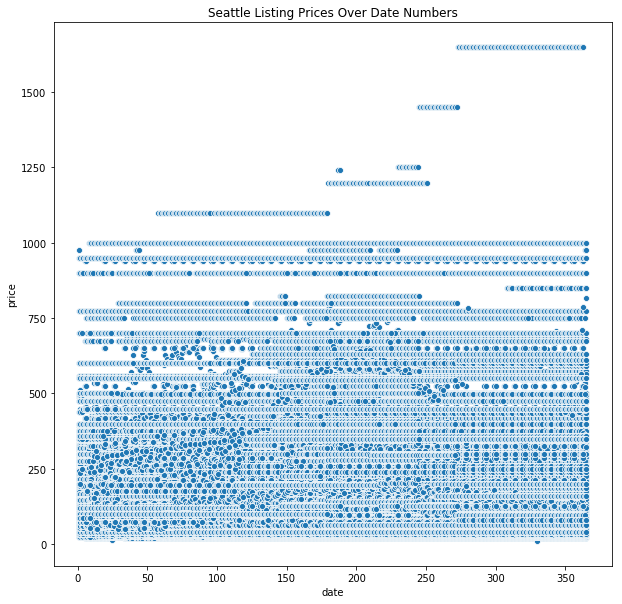

In [180]:
plt.figure(figsize=(10, 10));

plt.title("Seattle Listing Prices Over Date Numbers")
sns.scatterplot(x='date', 
                y='price', 
                data=df_calendar);
